In [1]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load Data dari GDrive
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import pickle

data = pd.read_csv('/content/Salinan preprocessed_dataSPAM.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 2. Install & Import Library
!pip install -q imbalanced-learn
!pip install -q tensorflow
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [3]:
# 3. Tampilkan dan Analisa Data
print(data.head())
print(data['target'].value_counts())  # Cek distribusi label

                                              review target
0            kemasan nya gak ada privasi sama sekali   REAL
1  sesuai foto  bahan lembut gak bikin gerah juga...   REAL
2  alhamdulillah sesuai harga cuma agak tipis sem...   REAL
3                          desain imut bagus menarik   REAL
4  alhamdulillah barang diterima dengan aman pesa...   REAL
target
REAL    8465
FAKE    1685
Name: count, dtype: int64


In [4]:
# 4. Ubah label: fake = 1, real = 0
data['label'] = data['target'].apply(lambda x: 1 if x == 'FAKE' else 0)
display(data.head())

,review,target,label
0,kemasan nya gak ada privasi sama sekali,REAL,0
1,sesuai foto bahan lembut gak bikin gerah juga...,REAL,0
2,alhamdulillah sesuai harga cuma agak tipis sem...,REAL,0
3,desain imut bagus menarik,REAL,0
4,alhamdulillah barang diterima dengan aman pesa...,REAL,0


In [5]:
# 5. Tokenisasi Data
texts = data['review'].astype(str).tolist()
labels = data['label'].values
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=300)

print("Contoh tokenisasi:")
print(sequences[:2])

X = pad_sequences(sequences, maxlen=300)
y = labels

Contoh tokenisasi:
[[264, 14, 42, 24, 1956, 68, 83], [10, 166, 19, 38, 42, 216, 825, 20, 340, 16, 233, 233, 89, 759, 14]]


In [6]:
# 6. Split Data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=labels
)

In [7]:
# 7. SMOTE Data Training (imbalance handling)
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [8]:
class BiLSTMBlock(layers.Layer):
    def __init__(self, units, output_shape, dropout_rate=0.5, kernel_regularizer=0.01, bias_regularizer=0.01, **kwargs):
        super().__init__(**kwargs)

        # Layer BiLSTM
        self.bilstm = layers.Bidirectional(layers.LSTM(units, return_sequences=True))

        # Dense pertama
        self.dense1 = layers.Dense(output_shape,
                                   kernel_initializer='he_uniform',  # Untuk distribusi bobot awal
                                   bias_initializer="zeros",
                                   kernel_regularizer=l2(kernel_regularizer),  # Regularisasi L2
                                   bias_regularizer=l2(bias_regularizer))
        self.bn1 = layers.BatchNormalization()      # Normalisasi
        self.act1 = layers.Activation("relu")       # Aktivasi ReLU
        self.dropout1 = layers.Dropout(dropout_rate)

        # Dense kedua
        self.dense2 = layers.Dense(output_shape,
                                   kernel_initializer='glorot_uniform',
                                   bias_initializer="zeros",
                                   kernel_regularizer=l2(kernel_regularizer),
                                   bias_regularizer=l2(bias_regularizer))
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.Activation("sigmoid")    # Output sigmoid untuk klasifikasi biner

    def call(self, inputs, training=None):
        x = self.bilstm(inputs)              # Melalui layer BiLSTM
        x = x[:, -1, :]                      # Ambil output pada time step terakhir
        x = self.dense1(x)                   # Dense layer pertama
        x = self.bn1(x, training=training)   # BatchNorm
        x = self.act1(x)                     # ReLU
        x = self.dropout1(x, training=training)
        x = self.dense2(x)                   # Dense layer kedua
        x = self.bn2(x, training=training)
        return self.act2(x)                  # Output sigmoid)

In [9]:
def build_bilstm_classifier_with_embedding(maxlen, vocab_size, output_shape,
                                           embed_dim=32, lstm_units=64, dropout_rate=0.5,
                                           kernel_regularizer=0.01, bias_regularizer=0.01):
    # 1. Input Layer: Bentuk input adalah (maxlen,)
    inputs = layers.Input(shape=(maxlen,), dtype="int32")

    # 2. Embedding Layer: Menyematkan kata-kata ke dalam vektor dimensi tetap
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)

    # 3. Blok BiLSTM: Layer kustom yang memuat BiLSTM dan Dense layer
    bilstm_block = BiLSTMBlock(units=lstm_units,
                               output_shape=output_shape,
                               dropout_rate=dropout_rate,
                               kernel_regularizer=kernel_regularizer,
                               bias_regularizer=bias_regularizer)

    # 4. Output Model: Output dari blok BiLSTM
    outputs = bilstm_block(x)

    # 5. Kembalikan model Keras
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [10]:
# 9. Training Model
maxlen = 300 # from your padding step
vocab_size = 10000 # from your tokenizer
output_shape = 1 # Since we are using sigmoid for binary classification

# Build the model using the defined function
model = build_bilstm_classifier_with_embedding(
    maxlen=maxlen,
    vocab_size=vocab_size,
    output_shape=output_shape,
    embed_dim=128, # adjust this and other hyperparameters
    lstm_units=64,
    dropout_rate=0.5,
    kernel_regularizer=0.001,
    bias_regularizer=0.001
)

model.summary()  #

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm_block (BiLSTMBlock)     │ (None, 1)              │        98,955 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,955 (5.26 MB)

 Trainable params: 1,378,951 (5.26 MB)

 Non-trainable params: 4 (16.00 B)

In [11]:
# 10. Compile Model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary() # Optional: Display model summary


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm_block (BiLSTMBlock)     │ (None, 1)              │        98,955 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,955 (5.26 MB)

 Trainable params: 1,378,951 (5.26 MB)

 Non-trainable params: 4 (16.00 B)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping configuration
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



In [13]:
# 12. Train the Model dengan EarlyStopping
history = model.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=64,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.6552 - loss: 0.6011 - val_accuracy: 0.5773 - val_loss: 0.6845
Epoch 2/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7129 - loss: 0.5490 - val_accuracy: 0.8818 - val_loss: 0.4658
Epoch 3/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7318 - loss: 0.5265 - val_accuracy: 0.9433 - val_loss: 0.3452
Epoch 4/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7314 - loss: 0.5198 - val_accuracy: 0.9074 - val_loss: 0.4321
Epoch 5/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7354 - loss: 0.5137 - val_accuracy: 0.9217 - val_loss: 0.3749
Epoch 6/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7496 - loss: 0.4974 - val_accuracy: 0.9325 - val_loss: 0.3202
Epoch 7/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7393 - loss: 0.5038 - val_accuracy: 0.9030 - val_loss: 0.3454
Epoch 8/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7427 - loss: 0.4990 - val

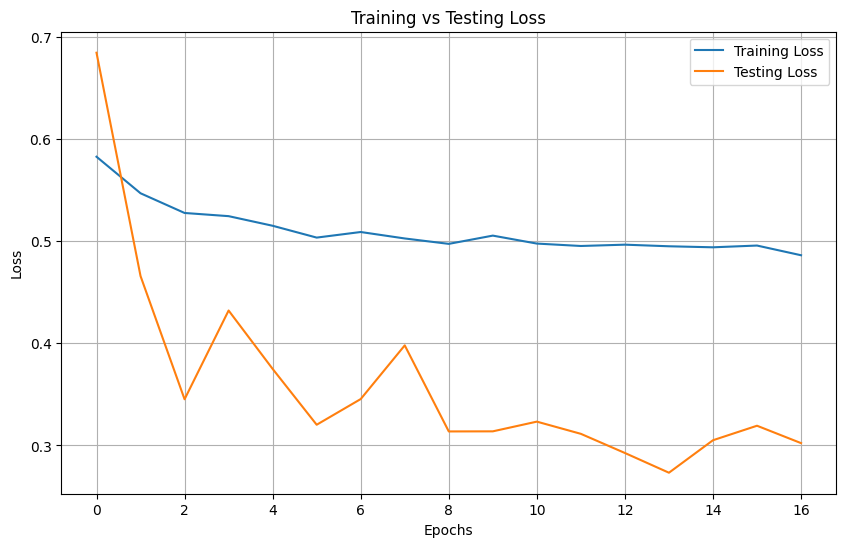

In [14]:
# 13. Plotting Training Loss vs Testing Loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training vs Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# 14. Evaluate the model further
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)  # Threshold untuk sigmoid output

# Evaluasi: Accuracy, Precision, F1 Score, Recall
from sklearn.metrics import recall_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))  # Menambahkan evaluasi Recall

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy: 0.9403940886699508
Precision: 0.7583732057416268
F1 Score: 0.8397350993377484
Recall: 0.9406528189910979


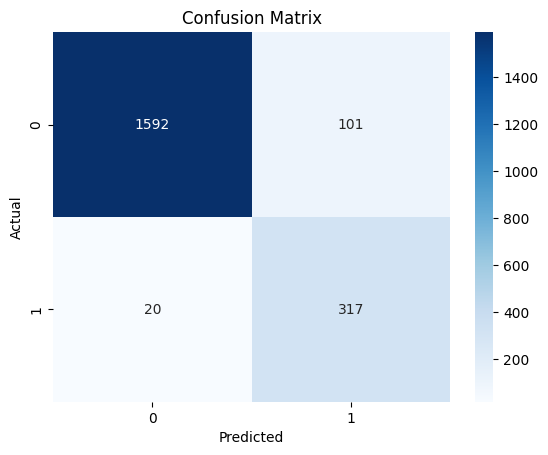

In [16]:
# 15. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
ROC AUC Score: 0.9699758650123304


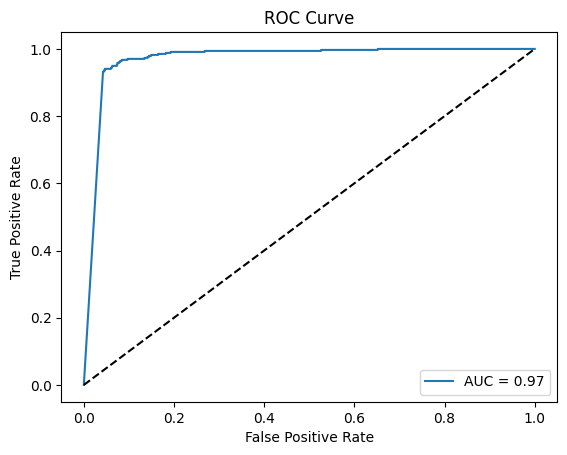

In [17]:
# 16. ROC AUC
y_pred_proba_positive = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba_positive)
print("ROC AUC Score:", auc_score)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_positive)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [18]:
# # 17. Save Model
# model.save("/content/BILSTMV4_model.keras")
# print("Model berhasil disimpan!")

In [19]:
model.save("BILSTMV4_model_2.h5")

In [20]:
# # 17. Save Model
# model.export("/content/drive/MyDrive/BILSTMV4_model")
# print("Model berhasil disimpan!")